**ToDo**

{ Important } update/fix image processing code variables

[ ] create helper functions
- start by creating functions to view images
- fix preprocessing into functions (done)



**Notes**

- When intializing model parameters (model weights), it's best to initialize  randomly.

Reason: If you were to intitialze the weights using np.zeros (with zeros), then it results in the model failing to break symmetry. Which means that every neuron in each layer is learning the same thing. Basically if the weights are zero then you're multiplying by a zero vector.

Outcome: Initilize weights randomly this way each neuron learns a different function of its input. You can initialize the bias vector with zeros.




- When itializing weights it's better to initialize with small numbers than large numbers

Reason: It slows down optimization and can lead to vanishing/exploding gradients

Outcome: When you have a ReLU function, HE initialization works best

Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import flax
from flax import linen as nn #Linen API

import tensorflow_datasets as tfds
import tensorflow as tf



## Helper Functions

In [15]:
#@title Loading and Preprocessing Datasets

def get_datasets(split, batch_size):
  ''' loading in the dataset'''
  dataset, ds_info = tfds.load(name='horses_or_humans', split=split, with_info=True)

  def _preprocess(dataset):
    ''' preprocessing the data '''
    image = dataset["image"]
    image = tf.image.resize(image, (224,224)) #resizing the image to a common size
    image = tf.cast(image, tf.float32)  #normalizes the pixel values of the images to the range [0,1]
    label = dataset["label"]

    return {'image': image, 'label':label}

  dataset = dataset.map(_preprocess) # applying the preprocessing fnc to each sample in the dataset
  dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE) #prefetch next sample(s) to improve latency using TF to automatically determine optimal # of samples to prefetch

  return dataset

##Exploring tfds

In [ ]:
#load the horses or humans dataset
# I don't think we have to one hot encode because 0 is the label for horeses and 1 is for human

# dataset_name = "horses_or_humans"
# ds_train, ds_info = tfds.load(name=dataset_name, split="train", with_info=True)

#splitting the set into training and testing
# num_training_ex = ds_info.splits["train"].num_examples
# num_testing_ex = ds_info.splits["test"].num_examples
# num_classes = ds.info.features["label"].num_classes

# ds_train = ds_train.take(num_training_ex // 2) # we're taking half of the training dataset (dividing by 2) to reduce training time and makes for a faster iteration
# ds_test = tfds.load(name=dataset_name, split="test")

In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_dir='/root/tensorflow_datasets/horses_or_humans/3.0.0',
    file_format=tfrecord,
    download_size=153.59 MiB,
    dataset_size=153.53 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
)


In [ ]:
# print(f"The number of training examples: {num_training_ex}")
# print(f"The number of training examples: {num_testing_ex}")

The number of training examples: 1027
The number of training examples: 256


##Data Preprocessing



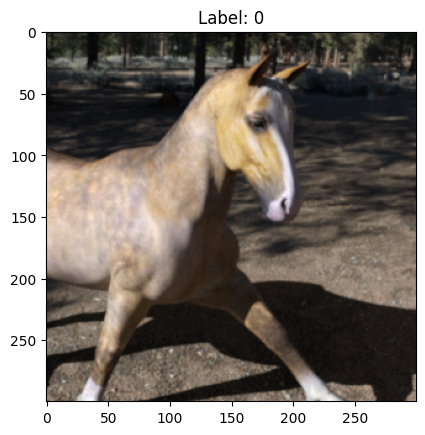

Shape of training example image: (300, 300, 3)


In [ ]:
#@title View one image before preprocessing

example_train, _ = tfds.load(name=dataset_name, split="train", with_info=True) # i can delete this created above
example_image = next(iter(example_train)) #taking only one example # should be using the variable ds_train here

raw_image = example_image["image"].numpy() #.numpy() method is used to convert tensorflow tensor to NumPy array before converting to matplot for visualizaiton
raw_label = example_image["label"].numpy() #numpy arrays works seamlessly with matplotlib you ensure compatability with matplotlib function plt.imshow()

plt.imshow(raw_image)
plt.title(f"Label: {raw_label}")
plt.show()

train_image_shape = raw_image.shape
print(f"Shape of training image: {train_image_shape}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteWJ4939/horses_or_humans-train.tfrecord*..…

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteWJ4939/horses_or_humans-test.tfrecord*...…

Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


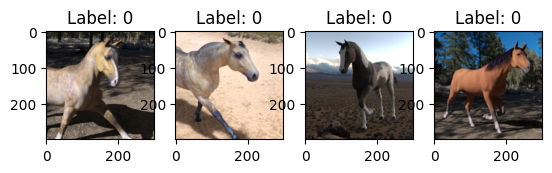

AttributeError: 'dict' object has no attribute 'shape'

In [5]:
#@title View multiple images before preprocessing

example_train, _ = tfds.load(name='horses_or_humans', split="train", with_info=True) #fix this line of code
num_images_to_display = 4 # fix this line of code

for idx, raw_image in enumerate(example_train.take(num_images_to_display)):
  image = raw_image["image"].numpy() #.numpy() method is used to convert tensorflow tensor to NumPy array before converting to matplot for visualizaiton
  label = raw_image["label"].numpy() #numpy arrays works seamlessly with matplotlib you ensure compatability with matplotlib function plt.imshow()

  plt.subplot(1, num_images_to_display, idx + 1)
  plt.imshow(image)
  plt.title(f"Label: {label}")

plt.show()

### Preprocessing

In [16]:
train_ds = get_datasets('train', 64)

In [23]:
print(len(train_ds)) #17 examples per batch (total of 1027 images using 64 batch size)

17


## Model

## Defining model

Because this is an image classification problem, I'm choosing to start with a simple CNN model

For my first model, I'm choosing to define the submodules/variables explicitly by using the setup method but we can also define this in-line using the nn.compact method.



In [ ]:
class CNN(nn.Module):
  """ A simple CNN model using setup method """
  hidden_dim: int = 64 # arbitrarily chose 64

  def setup(self):
    self.conv1 = nn.Conv(features=self.hidden_dim, kernel_size=(3,3))
    self.pool1 = nn.max_pool
    self.conv2 = nn.Conv(features=self.hidden_dim *2, kernel_size=(3,3))
    self.pool2 = nn.max_pool
    self.dense1 = nn.Dense(features=128)
    self.dense2 = nn.Dense(features=2)

  #forward pass
  def __call__(self, x):
    x = self.conv1(x)
    x = nn.relu(x)
    x = self.pool1(x, window_shape=(2,2), input_shape=x.shape[1:])
    x = self.conv2(x)
    x = nn.relu(x)
    x = self.pool2(x, window_shape=(2,2), input_shape=x.shape[1:])
    x = x.reshape((x.shape[0], -1)) #flattened to prepare for dense layer (x, _ = ravel_pytree(x) flatten using JAX's ravel_pytree)
    x = self.dense1(x)
    x = nn.relu(x)
    return self.dense2(x)

model = CNN()



## Initializing parameters

In [ ]:
key = jax.random.PRNGKey(0)
input_shape = (1, 224, 224,3) #input tensor with expected shape (batch_size, height, width, channels) RGB is 3
params = model.init(key, jnp.ones(input_shape, dtype = jnp.float32)) #this is wrong, we want to initialize weights randomly not with ones

## Loss function